In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

from spicy_snow.retrieval import retrieval_from_parameters

# import functions for downloading
from spicy_snow.download.sentinel1 import s1_img_search, hyp3_pipeline, download_hyp3, combine_s1_images
from spicy_snow.download.forest_cover import download_fcf
from spicy_snow.download.snow_cover import download_snow_cover

# import functions for pre-processing
from spicy_snow.processing.s1_preprocessing import merge_partial_s1_images, s1_orbit_averaging,\
s1_clip_outliers, subset_s1_images, ims_water_mask, s1_incidence_angle_masking, merge_s1_subsets

# import the functions for snow_index calculation
from spicy_snow.processing.snow_index import calc_delta_VV, calc_delta_cross_ratio, \
    calc_delta_gamma, clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth

# import the functions for wet snow flag
from spicy_snow.processing.wet_snow import id_newly_frozen_snow, id_newly_wet_snow, \
    id_wet_negative_si, flag_wet_snow

# setup root logger
from spicy_snow.utils.spicy_logging import setup_logging

# fischer z test
from causallearn.utils.cit import CIT

# random fields
from gstools import SRF
from gstools import vario_estimate_unstructured
from gstools import Exponential

In [2]:
def s1_to_sd(ds, A = 1.5, B = 0.1, C = 0.6):
    # mask out outliers in incidence angle
    ds = s1_incidence_angle_masking(ds)
    
    # subset dataset by flight_dir and platform
    dict_ds = subset_s1_images(ds)

    for subset_name, subset_ds in dict_ds.items():
        # average each orbit to overall mean
        dict_ds[subset_name] = s1_orbit_averaging(subset_ds)
        # clip outlier values of backscatter to overall mean
        dict_ds[subset_name] = s1_clip_outliers(subset_ds)
    
    # recombine subsets
    ds = merge_s1_subsets(dict_ds)

    # calculate confidence interval
    # ds = add_confidence_angle(ds)

    ## Snow Index Steps
    # log.info("Calculating snow index")
    # calculate delta CR and delta VV
    ds = calc_delta_cross_ratio(ds, A = A)
    ds = calc_delta_VV(ds)

    # calculate delta gamma with delta CR and delta VV with FCF
    ds = calc_delta_gamma(ds, B = B)

    # clip outliers of delta gamma
    ds = clip_delta_gamma_outlier(ds)

    # calculate snow_index from delta_gamma
    ds = calc_snow_index(ds, ims_masking = True)

    # convert snow index to snow depth
    ds = calc_snow_index_to_snow_depth(ds, C = C)

    return ds

import warnings
def get_gaussian_stats(da):
    arr = da.values
    warnings.filterwarnings("ignore", message="Mean of empty slice")
    warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 ")
    return arr.size, np.nanmean(arr), np.nanstd(arr), arr.shape

def bias(x, y): return np.mean(x - y)

def get_stats(x, y, nrmse = False):
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    if type(x) == list: x = np.array(x)
    if type(y) == list: y = np.array(y)
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)

    if nrmse:
        nrmse_value = rmse / np.mean(x)
        return r, b, mae, rmse, nrmse_value

    return r, b, mae, rmse

from scipy.stats import norm
def fischerz(truth, x1, x2):
    idx = (~np.isnan(truth)) & (~np.isnan(x1)) & (~np.isnan(x2))
    truth, x1, x2 = truth[idx], x1[idx], x2[idx]
    n = len(x1)
    cor1 = pearsonr(truth, x1).statistic
    cor2 = pearsonr(truth, x2).statistic
    fischer1 = 0.5*np.log((1+cor1)/(1-cor1))
    fischer2 = 0.5*np.log((1+cor2)/(1-cor2))
    expected_sd = np.sqrt(1/(n-3))
    return 2 * (1 - norm(0, expected_sd).cdf(np.abs(fischer1 - fischer2)))

def optimize(r_ds, A, B, C, im_date):
    # holds rmse and r for optimizing rand dataset
    rand_rmse_ds = xr.DataArray(np.zeros([len(A), len(B), len(C)]), dims = ['A', 'B', 'C'], coords = [A, B, C])
    rand_mae_ds = xr.DataArray(np.zeros([len(A), len(B), len(C)]), dims = ['A', 'B', 'C'], coords = [A, B, C])
    rand_r_ds = xr.DataArray(np.zeros([len(A), len(B), len(C)]), dims = ['A', 'B', 'C'], coords = [A, B, C])

    # optimize random dataset
    for a in A:
        for b in B:
            for c in C:
                r_ds_new = s1_to_sd(r_ds, A = a, B = b, C = c)
                r_sd_new = r_ds_new.where(r_ds_new['ims'] == 4)['snow_depth'].dropna(dim = 'time', how = 'all').sel(time = im_date, method = 'nearest')
                rand_r, rand_b, rand_mae, rand_rmse = get_stats(r_sd_new, r_ds_new['lidar-sd'], nrmse = False)
                rand_rmse_ds.loc[dict(A = a, B = b, C = C)] = rand_rmse
                rand_mae_ds.loc[dict(A = a, B = b, C = C)] = rand_mae
                rand_r_ds.loc[dict(A = a, B = b, C = C)] = rand_r
    
    return rand_rmse_ds, rand_mae_ds, rand_r_ds

def create_unstructured_grid(x_s, y_s):
    x_u, y_u = np.meshgrid(x_s, y_s)
    len_unstruct = len(x_s) * len(y_s)
    x_u = np.reshape(x_u, len_unstruct)
    y_u = np.reshape(y_u, len_unstruct)
    return x_u, y_u

def create_random_field(da):
    random_ds = da.copy(deep = True)
    arr = da.data
    x_u, y_u = create_unstructured_grid(da.x.data, da.y.data)
    bins = np.linspace(20, 1500, 20)
    bin_center, gamma = vario_estimate_unstructured(
            (x_u, y_u), arr.flatten(), bins, sampling_size=3000)
    fit_model = Exponential(dim=2, nugget= 0)
    fit_model.fit_variogram(bin_center, gamma, nugget=True)
    srf = SRF(fit_model, seed=19770928)
    # this transpose appears in all the documentation and is neccessary to make the data fit the original data
    random_ds.data = srf((da.x.data, da.y.data), mesh_type='structured').T

    return random_ds

def convert_to_utm(da): 
    da = da.rio.write_crs('EPSG:4326')
    if 'time' in da.dims:
        da = da.transpose('time', 'y', 'x')
    else:
        da = da.transpose('y', 'x')
    da = da.rio.reproject(da.rio.estimate_utm_crs())

    return da

def normalize_da(da):
    c_min, c_max = da.min(), da.max()
    da = (da - c_min) / (c_max - c_min)

    return da

def make_random_timeseries(ds):
    """
    Makes a random time series of s1 data with t0 VV having the same spatial correlation length and variances
    as the real data and VH @ t = 0 being a mean shifted version of the random VV @ t0. Then the difference from 
    t = 0 to t = n is calculated for eachtime step and a change with the same varaince and spatial correlation length
    is added to backscatter to t = 0.
    """
    ds = ds.rio.write_crs('EPSG:4326')
    random_ds = ds[['s1','fcf', 'ims']].copy(deep = True)

    for orbit_name, sub in ds.groupby('relative_orbit'):

        for band in ['VV','VH']:
            sub[band] = sub['s1'].sel(band = band)
        sub = sub.drop('s1')
        sub = sub.drop('band')
        sub = sub.transpose('time', 'y', 'x')
        sub = sub.rio.reproject(sub.rio.estimate_utm_crs())
        
        
        random_sub_ds = sub.copy(deep = True)
        
        # make a random visualization of VV @ t = 0 with matching variance and correlation length to real data
        random_sub_ds['VV'].loc[dict(time = sub.isel(time = 0).time)] = create_random_field(sub['VV'].isel(time = 0))

        # make VH @ t = 0 match VV with a shifted mean (arbitrary since we just use change in backscatter) to simulate the geometric drive correlation between the two 
        random_sub_ds['VH'].loc[dict(time = sub.isel(time = 0).time)] =  random_sub_ds['VV'].loc[dict(time = sub.isel(time = 0).time)] - 1
        
        sub['deltaVH'] = sub['VH'].diff(dim = 'time')

        for i, (ts, time_ds) in enumerate(sub.groupby('time')):
            if i == 0:
                continue
            # go through each time series with dVV and then dVH
            # add random field with matching spatial statistics to dVV and dVH to original image to make new timeseries
            for band in ['VV', 'VH']:
                random_sub_ds[band].loc[dict(time = ts)] = random_sub_ds[band].isel(time = 0) + create_random_field(time_ds[band] - random_sub_ds[band].isel(time = 0))
        
        
        for band in ['VV', 'VH']:
            random_ds['s1'].loc[dict(time = ds.relative_orbit == orbit_name, band = band)] = random_sub_ds[band].rio.reproject_match(random_ds['s1'].loc[dict(time = ds.relative_orbit == orbit_name, band = band)])

    return random_ds

def reorder_timeseries(dataset, ims = False):
    dataset = dataset.assign_coords(data_time = ('time', dataset.time.data))

    for orbit_name, sub in dataset.groupby('relative_orbit'):
        ts = sub.time
        reorder_ts = ts.to_dataframe().sample(n = len(ts), replace = False).index
        for (old_ts, new_ts) in zip(ts, reorder_ts):
            dataset['s1'].loc[dict(time = old_ts)] = dataset['s1'].sel(time = new_ts)
            dataset['data_time'].loc[dict(time = old_ts)] = pd.to_datetime(new_ts)
            if ims:
                dataset['ims'].loc[dict(time = old_ts)] = dataset['ims'].sel(time = new_ts)
        
    return dataset.sortby('time')

In [3]:
in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
out_dir = Path('/bsuhome/zacharykeskinen/spicy-analysis/results/synthetic_compare')
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

# Create parameter space
A = np.round(np.arange(1, 3.1, 0.5), 2)
B = np.round(np.arange(0, 2.01, 0.25), 2)
C = np.round(np.arange(0.25, 1.001, 0.25), 2)

In [32]:
ds = dss['Banner_2020-02-18']

In [65]:
def invert_timerseries(ds):
    random_ds = ds.copy(deep = True)
    for band in ['VV','VH']:
        for ts in ds.time:
            random_ds['s1'].loc[dict(time = ts, band = band)] = np.fliplr(np.flipud(ds['s1'].sel(time = ts, band = band)))

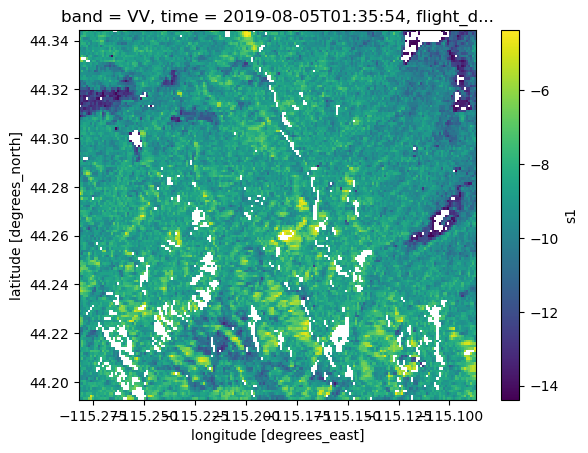

In [63]:
ds['s1'].sel(band = 'VV').isel(time = 0).plot()

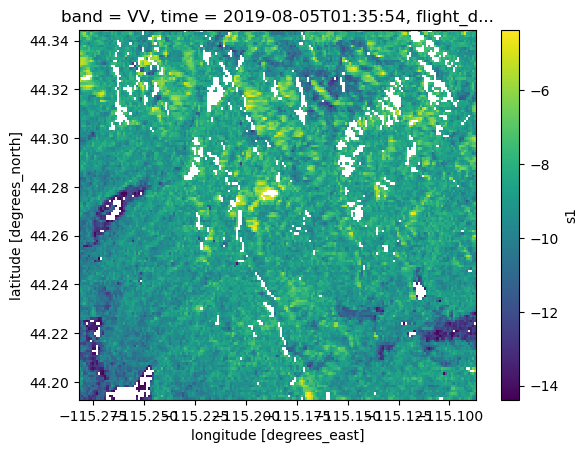

In [64]:
random_ds['s1'].sel(band = 'VV').isel(time = 0).plot()

# random field starting with matching VV and VH (with a contant offset) from the spatial statistics of VV @ t =0 and then iteratively add a random field calculated from that time steps dVV and dVH

In [ ]:
if out_dir.joinpath('synthetic_v1.csv').exists():
    res = pd.read_csv(out_dir.joinpath('synthetic_v1.csv'), index_col=0)
else:
    res = pd.DataFrame()
rands =[]
s1 = []
sd = []

# Create parameter space
A = np.round(np.arange(1, 3.1, 0.5), 2)
B = np.round(np.arange(0, 2.01, 0.25), 2)
C = np.round(np.arange(0.1, 1.001, 0.2), 2)

for stem, full_ds in dss.items():
    full_ds = full_ds.load()
    site_name = stem.replace('_', ' ').replace('Frasier', 'Fraser').split('-')[0]
    
    if site_name in res.index:
        pass
    
    # if stem != 'Little_Cottonwood_2021-03-18':
    #     continue
    # full_ds = full_ds.load().isel(time = slice(50, None))

    if stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(full_ds.sel(time = full_ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
    
    random_ds = make_random_timeseries(full_ds)

    # print values
    print(site_name + ' random created')
    
    random_ds['lidar-sd'] = full_ds['lidar-sd']
    rand_rmse_ds, rand_mae_ds, rand_r_ds = optimize(random_ds, A, B, C, im_date)

    a_best = rand_r_ds.max(['B', 'C']).idxmax('A')
    b_best = rand_r_ds.max(['C', 'A']).idxmax('B')
    c_best = rand_mae_ds.sel(A = a_best, B = b_best).idxmin('C')
    
    r_ds = s1_to_sd(random_ds, A = a_best, B = b_best, C = c_best).sel(time = im_date, method = 'nearest')
    ds = full_ds.sel(time = im_date, method = 'nearest')


    r, b, mae, rmse = get_stats(ds['snow_depth'], ds['lidar-sd'], nrmse = False)
    rand_r, rand_b, rand_mae, rand_rmse = get_stats(r_ds['snow_depth'], r_ds['lidar-sd'], nrmse = False)
    fischer_z = fischerz(ds['lidar-sd'].data.ravel(), ds['snow_depth'].data.ravel(), r_ds['snow_depth'].data.ravel())

    res.loc[site_name, 'random_r'] = rand_r
    res.loc[site_name, 'random_rmse'] = rand_rmse
    res.loc[site_name, 'fischerz'] = fischer_z
    res.loc[site_name, 'real_r'] = r
    res.loc[site_name, 'real_rmse'] = rmse
    
    rands.append(r_ds['snow_depth'].data.ravel())
    s1.append(ds['snow_depth'].data.ravel())
    sd.append(ds['lidar-sd'].data.ravel())

    res.to_csv(out_dir.joinpath('synthetic_v1.csv'))
    print(site_name + ' done')

rands, sd, s1 = np.concatenate(rands), np.concatenate(sd), np.concatenate(s1)

rand_r, rand_b, rand_mae, rand_rmse = get_stats(rands, sd)
r, b, mae, rmse = get_stats(s1, sd)

res.loc['All Sites', 'random_r'] = rand_r
res.loc['All Sites', 'random_rmse'] = rand_rmse
res.loc['All Sites', 'real_r'] = r
res.loc['All Sites', 'real_rmse'] = rmse
res.loc['All Sites', 'fischerz'] = fischerz(sd, s1, rands)
res.to_csv(out_dir.joinpath('synthetic_v1.csv'))

# adding increasing gaussian noise to s1 vv and vh

# reordering VV and VH images

In [2]:
i = 1
outfp = out_dir.joinpath('rounds', f'reordered_all_v{i}.csv')
while outfp.exists():
    i += 1
    outfp = out_dir.joinpath('rounds', f'reordered_all_v{i}.csv')


res = pd.DataFrame()

# rands =[]
# s1 = []
# sd = []

# Create parameter space
A = np.round(np.arange(1, 3.1, 1), 2)
B = np.round(np.arange(0, 2.01, 1), 2)
C = np.round(np.arange(0.1, 1.001, 0.5), 2)

in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
out_dir = Path('/bsuhome/zacharykeskinen/spicy-analysis/results/synthetic_compare')
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}


dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}
for stem, full_ds in dss.items():
    full_ds = full_ds.load()
    for cond in ['all_random', 's1_ims_random', 's1_random']:
        for round in range(10):
            site_name = stem.replace('_', ' ').replace('Frasier', 'Fraser').split('-')[0]

            # if site_name in res.index:
            #     pass
            
            # if stem != 'Little_Cottonwood_2021-03-18':
            #     continue
            # full_ds = full_ds.load().isel(time = slice(50, None))

            if stem == 'Frasier_2020-02-11':
                im_date = pd.to_datetime('2020-02-16')
            else:
                # im_date = pd.to_datetime(full_ds.sel(time = full_ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
                im_date = pd.to_datetime(stem.split('_')[-1])
            
            ds = full_ds.sel(time = im_date, method = 'nearest')

            if site_name not in res.index:
                r, b, mae, rmse = get_stats(ds['snow_depth'], ds['lidar-sd'], nrmse = False)
                res.loc[site_name, 'real_r' + suffix] = r
                res.loc[site_name, 'real_rmse' + suffix] = rmse
                res.loc[site_name, 'mean_snowdepth'] = ds['lidar-sd'].mean().data.ravel()[0]
                res.loc[site_name, 'fcf_mean'] = ds['fcf'].mean().data.ravel()[0]
                res.loc[site_name, 'dry_percentage'] = ds['wet_snow'].mean().data.ravel()[0]

            random_ds = full_ds.copy(deep = True)
            random_ds= random_ds.rio.write_crs('EPSG:4326')
            
            if cond == 's1_ims_random':
                random_ds = reorder_timeseries(random_ds, ims = False)[['s1', 'ims', 'fcf']]
            elif cond == 's1_random':
                random_ds = reorder_timeseries(random_ds, ims = True)[['s1', 'ims', 'fcf']]
            if cond == 'all_random':
                random_ds['fcf'] = normalize_da(create_random_field(convert_to_utm(random_ds['fcf'])).rio.reproject_match(random_ds['fcf']))
            # random_ds['s1'].loc[dict(band = ['VV','VH'])] = random_ds['s1'].sel(band = ['VV','VH']).dropna(dim = 'time', how = 'all')

            # print values
            # print(site_name + ' random created')
            
            random_ds['lidar-sd'] = full_ds['lidar-sd']
            rand_rmse_ds, rand_mae_ds, rand_r_ds = optimize(random_ds, A, B, C, im_date)

            a_best = rand_r_ds.max(['B', 'C']).idxmax('A')
            b_best = rand_r_ds.max(['C', 'A']).idxmax('B')
            c_best = rand_mae_ds.sel(A = a_best, B = b_best).idxmin('C')
            
            r_ds_full = s1_to_sd(random_ds, A = a_best, B = b_best, C = c_best)
            
            r_ds = r_ds_full.sel(time = im_date, method = 'nearest')

            # if site_name == 'Banner 2020':
            #     break
            rand_r, rand_b, rand_mae, rand_rmse = get_stats(r_ds['snow_depth'], r_ds['lidar-sd'], nrmse = False)
            fischer_z = fischerz(ds['lidar-sd'].data.ravel(), ds['snow_depth'].data.ravel(), r_ds['snow_depth'].data.ravel())

            col_name = site_name + '-' + cond
            suffix = '-' + str(round)
            res.loc[col_name, 'random_r' + suffix] = rand_r
            res.loc[col_name, 'random_rmse' + suffix] = rand_rmse
            res.loc[col_name, 'fischerz' + suffix] = fischer_z
            
            # rands.append(r_ds['snow_depth'].data.ravel())
            # s1.append(ds['snow_depth'].data.ravel())
            # sd.append(ds['lidar-sd'].data.ravel())

            res.to_csv(outfp)
            # print(site_name + ' done')

# rands, sd, s1 = np.concatenate(rands), np.concatenate(sd), np.concatenate(s1)

# rand_r, rand_b, rand_mae, rand_rmse = get_stats(rands, sd)
# r, b, mae, rmse = get_stats(s1, sd)

# res.loc['All Sites', 'random_r'] = rand_r
# res.loc['All Sites', 'random_rmse'] = rand_rmse
# res.loc['All Sites', 'real_r'] = r
# res.loc['All Sites', 'real_rmse'] = rmse
# res.loc['All Sites', 'fischerz'] = fischerz(sd, s1, rands)
res.to_csv(outfp)

NameError: name 'out_dir' is not defined

In [1]:
print('importing')

from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

from spicy_snow.retrieval import retrieval_from_parameters

# import functions for downloading
from spicy_snow.download.sentinel1 import s1_img_search, hyp3_pipeline, download_hyp3, combine_s1_images
from spicy_snow.download.forest_cover import download_fcf
from spicy_snow.download.snow_cover import download_snow_cover

# import functions for pre-processing
from spicy_snow.processing.s1_preprocessing import merge_partial_s1_images, s1_orbit_averaging,\
s1_clip_outliers, subset_s1_images, ims_water_mask, s1_incidence_angle_masking, merge_s1_subsets

# import the functions for snow_index calculation
from spicy_snow.processing.snow_index import calc_delta_VV, calc_delta_cross_ratio, \
    calc_delta_gamma, clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth

# import the functions for wet snow flag
from spicy_snow.processing.wet_snow import id_newly_frozen_snow, id_newly_wet_snow, \
    id_wet_negative_si, flag_wet_snow

# setup root logger
from spicy_snow.utils.spicy_logging import setup_logging

# fischer z test
from causallearn.utils.cit import CIT

# random fields
from gstools import SRF
from gstools import vario_estimate_unstructured
from gstools import Exponential

def s1_to_sd(ds, A = 1.5, B = 0.1, C = 0.6):
    # mask out outliers in incidence angle
    ds = s1_incidence_angle_masking(ds)
    
    # subset dataset by flight_dir and platform
    dict_ds = subset_s1_images(ds)

    for subset_name, subset_ds in dict_ds.items():
        # average each orbit to overall mean
        dict_ds[subset_name] = s1_orbit_averaging(subset_ds)
        # clip outlier values of backscatter to overall mean
        dict_ds[subset_name] = s1_clip_outliers(subset_ds)
    
    # recombine subsets
    ds = merge_s1_subsets(dict_ds)

    # calculate confidence interval
    # ds = add_confidence_angle(ds)

    ## Snow Index Steps
    # log.info("Calculating snow index")
    # calculate delta CR and delta VV
    ds = calc_delta_cross_ratio(ds, A = A)
    ds = calc_delta_VV(ds)

    # calculate delta gamma with delta CR and delta VV with FCF
    ds = calc_delta_gamma(ds, B = B)

    # clip outliers of delta gamma
    ds = clip_delta_gamma_outlier(ds)

    # calculate snow_index from delta_gamma
    ds = calc_snow_index(ds, ims_masking = True)

    # convert snow index to snow depth
    ds = calc_snow_index_to_snow_depth(ds, C = C)

    return ds

import warnings
def get_gaussian_stats(da):
    arr = da.values
    warnings.filterwarnings("ignore", message="Mean of empty slice")
    warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 ")
    return arr.size, np.nanmean(arr), np.nanstd(arr), arr.shape

def get_bias(x, y): return np.mean(x - y)

def get_stats(x, y, nrmse = False):
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    if type(x) == list: x = np.array(x)
    if type(y) == list: y = np.array(y)
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    if len(x) <4 or len(y)<4:
        if nrmse:
            return np.nan, np.nan, np.nan, np.nan, np.nan
        return np.nan, np.nan, np.nan, np.nan
    r, p = pearsonr(x, y)
    bias = get_bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)

    if nrmse:
        nrmse_value = rmse / np.mean(x)
        return r, b, mae, rmse, nrmse_value

    return r, bias, mae, rmse

from scipy.stats import norm
def fischerz(truth, x1, x2):
    idx = (~np.isnan(truth)) & (~np.isnan(x1)) & (~np.isnan(x2))
    truth, x1, x2 = truth[idx], x1[idx], x2[idx]
    n = len(x1)
    cor1 = pearsonr(truth, x1).statistic
    cor2 = pearsonr(truth, x2).statistic
    fischer1 = 0.5*np.log((1+cor1)/(1-cor1))
    fischer2 = 0.5*np.log((1+cor2)/(1-cor2))
    expected_sd = np.sqrt(1/(n-3))
    return 2 * (1 - norm(0, expected_sd).cdf(np.abs(fischer1 - fischer2)))

def optimize(r_ds, A, B, C, im_date):
    # holds rmse and r for optimizing rand dataset
    rand_rmse_ds = xr.DataArray(np.zeros([len(A), len(B), len(C)]), dims = ['A', 'B', 'C'], coords = [A, B, C])
    rand_mae_ds = xr.DataArray(np.zeros([len(A), len(B), len(C)]), dims = ['A', 'B', 'C'], coords = [A, B, C])
    rand_r_ds = xr.DataArray(np.zeros([len(A), len(B), len(C)]), dims = ['A', 'B', 'C'], coords = [A, B, C])

    # optimize random dataset
    for a in A:
        for b in B:
            for c in C:
                r_ds_new = s1_to_sd(r_ds, A = a, B = b, C = c)
                r_sd_new = r_ds_new.where(r_ds_new['ims'] == 4)['snow_depth'].dropna(dim = 'time', how = 'all').sel(time = im_date, method = 'nearest')
                rand_r, rand_b, rand_mae, rand_rmse = get_stats(r_sd_new, r_ds_new['lidar-sd'], nrmse = False)
                rand_rmse_ds.loc[dict(A = a, B = b, C = C)] = rand_rmse
                rand_mae_ds.loc[dict(A = a, B = b, C = C)] = rand_mae
                rand_r_ds.loc[dict(A = a, B = b, C = C)] = rand_r
    
    return rand_rmse_ds, rand_mae_ds, rand_r_ds

def create_unstructured_grid(x_s, y_s):
    x_u, y_u = np.meshgrid(x_s, y_s)
    len_unstruct = len(x_s) * len(y_s)
    x_u = np.reshape(x_u, len_unstruct)
    y_u = np.reshape(y_u, len_unstruct)
    return x_u, y_u

def create_random_field(da):
    random_ds = da.copy(deep = True)
    arr = da.data
    x_u, y_u = create_unstructured_grid(da.x.data, da.y.data)
    bins = np.linspace(20, 1500, 20)
    bin_center, gamma = vario_estimate_unstructured(
            (x_u, y_u), arr.flatten(), bins, sampling_size=3000)
    fit_model = Exponential(dim=2, nugget= 0)
    fit_model.fit_variogram(bin_center, gamma, nugget=True)
    srf = SRF(fit_model, seed=19770928)
    # this transpose appears in all the documentation and is neccessary to make the data fit the original data
    random_ds.data = srf((da.x.data, da.y.data), mesh_type='structured').T

    return random_ds

def convert_to_utm(da): 
    da = da.rio.write_crs('EPSG:4326')
    if 'time' in da.dims:
        da = da.transpose('time', 'y', 'x')
    else:
        da = da.transpose('y', 'x')
    da = da.rio.reproject(da.rio.estimate_utm_crs())

    return da

def normalize_da(da):
    c_min, c_max = da.min(), da.max()
    da = (da - c_min) / (c_max - c_min)

    return da

def reorder_timeseries(dataset, ims = False):
    dataset = dataset.assign_coords(data_time = ('time', dataset.time.data))

    for orbit_name, sub in dataset.groupby('relative_orbit'):
        ts = sub.time
        reorder_ts = ts.to_dataframe().sample(n = len(ts), replace = False).index
        for (old_ts, new_ts) in zip(ts, reorder_ts):
            dataset['s1'].loc[dict(time = old_ts)] = dataset['s1'].sel(time = new_ts)
            dataset['data_time'].loc[dict(time = old_ts)] = pd.to_datetime(new_ts)
            if ims:
                dataset['ims'].loc[dict(time = old_ts)] = dataset['ims'].sel(time = new_ts)
        
    return dataset.sortby('time')

# Create parameter space
A = np.round(np.arange(1, 3.1, 1), 2)
B = np.round(np.arange(0, 2.01, 1), 2)
C = np.round(np.arange(0.25, 1.001, 0.5), 2)

in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
out_dir = Path('/bsuhome/zacharykeskinen/spicy-analysis/results/synthetic_compare')
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}


# def make_random_results(out_dir, A, B, C, fp):
for fp in in_dir.glob('*.nc'):
    print(fp)
    stem = fp.stem
    # ds, stem = ds_pair
    full_ds = xr.open_dataset(fp)
    full_ds = full_ds.load()
    full_ds = full_ds.where(full_ds['lidar-sd'] > 1.5)

    site_name = stem.replace('_', ' ').replace('Frasier', 'Fraser').split('-')[0]
    im_date = pd.to_datetime(stem.split('_')[-1])

    i = 1
    outfp = out_dir.joinpath('deep', f'{site_name}_{i}.csv')
    while outfp.exists():
        i += 1
        outfp = out_dir.joinpath('deep', f'{site_name}_{i}.csv')

    res = pd.DataFrame(index = pd.MultiIndex.from_tuples(list(zip([], [])), names=["condition", "round"]))

    ds = full_ds.sel(time = im_date, method = 'nearest').copy()

    if site_name not in res.index:
        r, b, mae, rmse = get_stats(ds['snow_depth'], ds['lidar-sd'], nrmse = False)
        
        res.loc[(site_name, 0), 'real_r'] = r
        res.loc[(site_name, 0), 'real_rmse'] = rmse
        res.loc[(site_name, 0), 'mean_snowdepth'] = ds['lidar-sd'].mean().data.ravel()[0]
        res.loc[(site_name, 0), 'fcf_mean'] = ds['fcf'].mean().data.ravel()[0]
        res.loc[(site_name, 0), 'dry_percentage'] = ds['wet_snow'].mean().data.ravel()[0]
        res.loc[(site_name, 0), 'valid-sd'] = (~ds['lidar-sd'].isnull()).sum().data.ravel()[0]

        rand_rmse_ds, rand_mae_ds, rand_r_ds = optimize(full_ds, A, B, C, im_date)

        a_best = rand_r_ds.max(['B', 'C']).idxmax('A')
        b_best = rand_r_ds.max(['C', 'A']).idxmax('B')
        c_best = rand_mae_ds.sel(A = a_best, B = b_best).idxmin('C')
        
        full_ds = s1_to_sd(full_ds, A = a_best, B = b_best, C = c_best)

        r, b, mae, rmse = get_stats(full_ds.sel(time = im_date, method = 'nearest')['snow_depth'], ds['lidar-sd'], nrmse = False)
        res.loc[(site_name, 0), 'optimized_r'] = r
        res.loc[(site_name, 0), 'optimized_rmse'] = rmse
    
    for cond in ['fcf_s1_random', 's1_random']:
        for round_i in range(10):
    
            random_ds = full_ds.copy(deep = True)
            random_ds= random_ds.rio.write_crs('EPSG:4326')
            
            if cond == 'fcf_s1_random' or cond == 's1_random':
                random_ds = reorder_timeseries(random_ds, ims = False)[['s1', 'ims', 'fcf']]
            # elif cond == 's1_random':
            #     random_ds = reorder_timeseries(random_ds, ims = False)[['s1', 'ims', 'fcf']]
            if cond == 'fcf_s1_random':
                random_ds['fcf'] = normalize_da(create_random_field(convert_to_utm(random_ds['fcf']).where(convert_to_utm(random_ds['fcf']) < 10000)).rio.reproject_match(random_ds['fcf']))

            random_ds['lidar-sd'] = ds['lidar-sd']

            rand_rmse_ds, rand_mae_ds, rand_r_ds = optimize(random_ds, A, B, C, im_date)

            a_best = rand_r_ds.max(['B', 'C']).idxmax('A')
            b_best = rand_r_ds.max(['C', 'A']).idxmax('B')
            c_best = rand_mae_ds.sel(A = a_best, B = b_best).idxmin('C')
            
            r_ds_full = s1_to_sd(random_ds, A = a_best, B = b_best, C = c_best)
            
            r_sd = r_ds_full.where(r_ds_full['ims'] == 4)['snow_depth'].dropna(dim = 'time', how = 'all').sel(time = im_date, method = 'nearest')

            rand_r, rand_b, rand_mae, rand_rmse = get_stats(r_sd, ds['lidar-sd'], nrmse = False)
            fischer_z = fischerz(ds['lidar-sd'].data.ravel(), ds['snow_depth'].data.ravel(), r_sd.data.ravel())

            res.loc[(cond, round_i), 'random_r'] = rand_r
            res.loc[(cond, round_i), 'random_rmse'] = rand_rmse
            res.loc[(cond, round_i), 'fischerz'] = fischer_z
            

            res.to_csv(outfp)

from multiprocessing import Pool
from functools import partial

print('starting')
in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
out_dir = Path('/bsuhome/zacharykeskinen/spicy-analysis/results/synthetic_compare')

# Create parameter space
A = np.round(np.arange(1, 3.1, 0.5), 2)
B = np.round(np.arange(0, 2.01, 0.25), 2)
C = np.round(np.arange(0.25, 1.001, 0.25), 2)

out_dir.joinpath('sites').mkdir(exist_ok = True)

pool = Pool()

pool.map(partial(make_random_results, out_dir.joinpath('sites'), A, B, C), list(in_dir.glob('*.nc')))

importing
/bsuscratch/zacharykeskinen/spicy/SnowEx-Data/Mores_2020-02-09.nc


KeyboardInterrupt: 

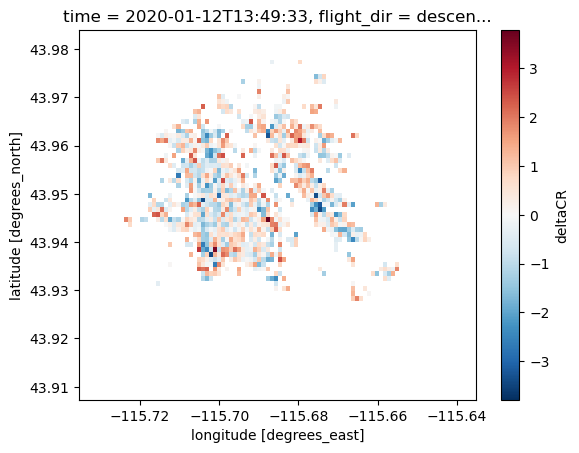

In [14]:
full_ds.where(full_ds['lidar-sd'] > 2)['deltaCR'].isel(time = 30).plot()

In [11]:
(~ds['lidar-sd'].isnull()).sum().data.ravel()[0]

3209